<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Natural Language Processing: Classification
              
</p>
</div>

Data Science Cohort Live NYC July 2022
<p>Phase 4: Topic 39</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [1]:
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.pardir)
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [3]:
import numpy as np
import pandas as pd

# importing text preprocessing libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


In [4]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

Build a very simple stateless transformer:
- Cleans/preprocesses text

In [5]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [6]:
data = pd.read_csv('Data/satire_nosatire.csv')
X = data['body']
y = data['target']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

proc = TextPreprocessor()

# again this kind of splitting only becomes important if fitting of text transformers fits to statistics of the text corpus
transformed_train = proc.fit_transform(X_train) 


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [9]:
prc_steps = [('countvec', CountVectorizer(min_df = 0.05, max_df = 0.95))]
preprocess_pipeline = Pipeline(prc_steps)

In [10]:
X_tr_proc = preprocess_pipeline.fit_transform(transformed_train)

In [11]:
X_tr_proc

<700x608 sparse matrix of type '<class 'numpy.int64'>'
	with 45409 stored elements in Compressed Sparse Row format>

In [12]:
feat_names = preprocess_pipeline[
    'countvec'].get_feature_names_out()

pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)

,able,access,accord,account,accuse,achieve,act,action,actually,add,...,woman,word,work,worker,world,write,year,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,5,0,2,0,0,0
3,0,0,1,0,0,1,0,0,0,1,...,0,0,2,0,0,1,1,0,0,0
4,0,0,2,0,0,0,0,0,0,1,...,2,0,0,0,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,0,0,0,0,0,1,0,1,0,1,...,0,0,2,0,0,2,7,0,1,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Building a document classifier model

**Naive Bayes with Multinomial Distribution Likelihood**

- Can be effective for modeling document-term frequency matrix to target class relationships

Bayes theorem:

$$ P(c|\textbf{x}) = \frac{P(\textbf{x}|c)P(c)}{P(\textbf{x})} $$

- Likelihood; $P(\textbf{x}|c)$
- Prior: $P(c)$
- Posterior: $P(c|\textbf{x}) $

Bayes classifier:
    
$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} P(\textbf{x}|c)P(c)$$

#### Prior
- simply the target fraction

In [13]:
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

1    0.511429
0    0.488571
Name: target, dtype: float64

#### The likelihood function

**First step: word count distribution**:

- Multinomial distribution (generalization of 
binomial distribution)

For document with $m$ tokens:
- dictionary of corpus has $d$ unique tokens.
- $\textbf{x} = (x_1,...., x_d)$ vector of token counts for document.



An analogy: $d = 6$ M&M colors

Picking $ m $ M&Ms.

<img src = "Images/picking_candy.jpg" >
    
Follow multinomial distribution.


<a href = "https://www.mashed.com/679227/the-rarest-mm-color-may-surprise-you/#:~:text=Brown%20is%20currently%20the%20rarest%20color%20of%20M%26M's&text=As%20such%2C%20they%20used%20their,their%20findings%20were%20quite%20surprising."> Some interesting facts about M&Ms. </a>

$$ P(\textbf{x}|\theta) = \frac{m!}{x_1!x_2!...x_d!} \theta_{1}^{x_1}\theta_{2}^{x_2}...\theta_{d}^{x_d} $$
Parameters of distribution:
- $\theta_i$: probability of picking $i^{th}$ token  in dictionary from bag of words

**To be estimated from the data**

Words draws/order are **independent** of each other: the **naive** assumption.

<img src = "Images/scrabble.webp" />

#### Second Step: class conditional word count

$$ P(\textbf{x}|c) = \frac{m!}{x_1!x_2!...x_d!} [\theta_c]_{1}^{x_1}[\theta_c]_{2}^{x_2}...[\theta_c]_{d}^{x_d} $$
- $[\theta_c]$ is **class-dependent** set of probability parameters.

Need to fit probability parameters from data.

**Fitting probability parameters for each class**

- Very straightforward.
- Probability of drawing token $i$ if document class $c$

$$ [\hat{\theta}_c]_i = \frac{N_{ci}}{N_c}$$

- Count token $i$ occurence across all documents of class $c$
- Divide by total token count for all documents of class $c$

#### Getting the fit parameters with code

In [14]:
bow_mat = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
bow_mat['target'] = y_train
bow_mat

,able,access,accord,account,accuse,achieve,act,action,actually,add,...,woman,word,work,worker,world,write,year,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,5,0,2,0,0,0
3,0,0,1,0,0,1,0,0,0,1,...,0,0,2,0,0,1,1,0,0,0
4,0,0,2,0,0,0,0,0,0,1,...,2,0,0,0,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,0,0,0,0,0,1,0,1,0,1,...,0,0,2,0,0,2,7,0,1,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
class1_bow_mat = bow_mat[bow_mat['target'] == 1].drop(columns = ['target'])

# class 1 token probabilities:
N_tok_1 = class1_bow_mat.sum(axis = 0) # token occurence
N_1 =  class1_bow_mat.values.sum() # number of tokens

# get probabilities for each token: class 1
proba_c1 = N_tok_1/N_1

proba_c1.sort_values(ascending = False)[0:10]

say           0.032437
people        0.009972
year          0.009097
trump         0.008248
take          0.007877
state         0.007665
make          0.006922
get           0.006896
government    0.006737
time          0.006551
dtype: float64

In [16]:
class0_bow_mat = bow_mat[bow_mat['target'] == 0].drop(columns = ['target'])

# class 1 token probabilities:
N_tok_0 = class0_bow_mat.sum(axis = 0)
N_0 =  class0_bow_mat.values.sum() 

# get probabilities for each token: class 0
proba_c0 = N_tok_0/N_0

proba_c0.sort_values(ascending = False)[0:10]

say           0.032296
people        0.012845
year          0.010790
trump         0.009542
state         0.008514
also          0.007634
new           0.007634
see           0.007340
government    0.007340
right         0.006533
dtype: float64

#### Computing likelihood

In [17]:
from scipy.stats import multinomial

Take document:

In [18]:
X_train.iloc[50]

' U.S. House Speaker Nancy Pelosi said on Friday lawmakers cannot resolve the issue of border security until the government is reopened, telling reporters that a meeting with President Donald Trump about the standoff over funding for his long-promised border wall and the federal shutdown was contentious. “We just completed a lengthy and sometimes contentious conversation with the president. We agreed that we would continue our conversations. But we recognise on the Democratic side that we really cannot resolve this until we open up government and we made that very clear to the president,” Pelosi told reporters at the White House after meeting with Trump.'

In [19]:
# bow vector for document
bow_mat_feat = bow_mat.drop(columns = ['target'])
word_vec = bow_mat_feat.iloc[50]
word_vec

able       0
access     0
accord     0
account    0
accuse     0
          ..
write      0
year       0
yes        0
yet        0
young      0
Name: 50, Length: 607, dtype: int64

This is satire.

In [20]:
y_train.iloc[50]

0

In [21]:
article_length = word_vec.sum()
article_length

35

In [22]:
class1_likelihood = multinomial.pmf(x = word_vec.values, n = article_length, p =  proba_c1.values)
class0_likelihood = multinomial.pmf(x = word_vec.values, n = article_length, p =  proba_c0.values)

Now use Bayes theorem for classifier:

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} P(\textbf{x}|c)P(c)$$


with multinomial likelihood

$$ P(\textbf{x}|c) = \frac{m!}{x_1!x_2!...x_d!} [\hat{\theta}_c]_{1}^{x_1}[\hat{\theta}_c]_{2}^{x_2}...[\hat{\theta}_c]_{d}^{x_d} $$

and fitted parameters

$$ [\hat{\theta}_c]_i = \frac{N_{ci}}{N_c}$$

Evaluate class for this document:

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} P(\textbf{x}|c)P(c)$$

In [23]:
class1_likelihood*class_priors[1]

3.919275451202266e-53

In [24]:
class0_likelihood*class_priors[0]

1.6422200799992512e-53

Given scale of probabilities:
- Comparison done on log scale

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} \Big[ \log\Big(P(\textbf{x}|c)P(c)\Big) \Big]$$

In [25]:
np.log10(class1_likelihood*class_priors[1])

-52.40679421273182

In [26]:
np.log10(class0_likelihood*class_priors[0])

-52.78456864190325

#### Laplace Smoothing: practical correction

- A fudge count $\alpha$ added to token count in each class.
- Avoids issues with having zero counts $N_c$ and $N_{ci}$ in training set.

$$ [\hat{\theta}_c]_i = \frac{N_{ci} + \alpha}{N_c + \alpha d}$$

- Typically $\alpha = 1$. Can tune this.

- $d$ is the dimensionality of our vocabulary
- $N_{ci}$ the count of token $i$ in class $c$
- $N_{c}$ the count of all tokens in class $c$

Append Multinomial Naive Bayes Classifier to pipeline.

In [27]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
from copy import deepcopy
mod_pipe = deepcopy(preprocess_pipeline)
mod_pipe.steps.append(('multinb', MultinomialNB()))
mod_pipe.steps

[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [45]:
mod_pipe.fit(transformed_train, y_train)

Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [46]:
transformed_test = proc.transform(X_test)

y_pred = mod_pipe.predict(X_test) # automatically applies transforms and predicts on test

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       158
           1       0.91      0.99      0.95       142

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



In [48]:
roc_auc_score(y_test, y_pred)

0.9486539490105188

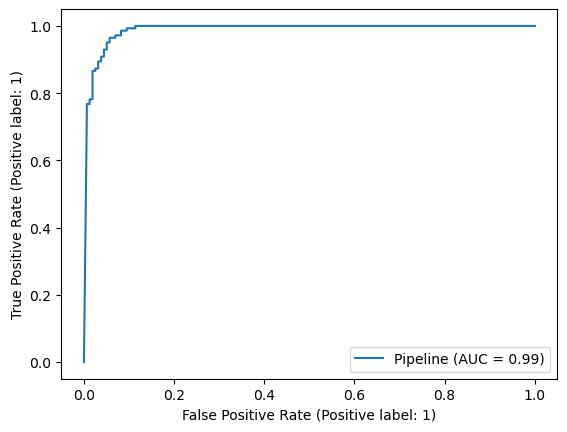

In [49]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(mod_pipe, X_test, y_test)

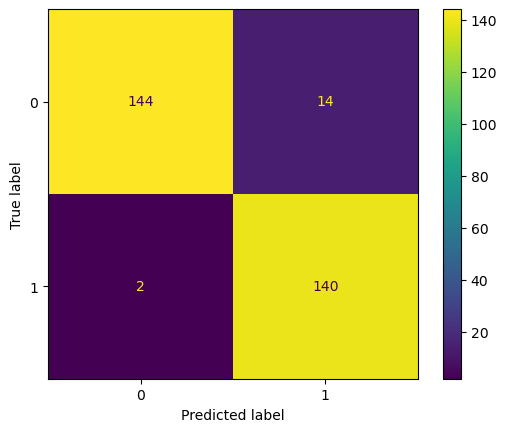

In [50]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(mod_pipe, X_test, y_test);

- with proper text preprocessing steps
- Naive Bayes can perform really well on simple binary classification tasks.

#### Using TF-IDF

TFIDF does not necessarily perform better than CV:
- It is just a tool in our toolbelt often worth trying out.

In [51]:
from copy import deepcopy
tfidfmod_pipe = deepcopy(mod_pipe)
#tfidfmod_pipe.steps[0] = ('tfidf', TfidfVectorizer(min_df=0.05, max_df=0.95)) # cuts words too rare/too frequent
tfidfmod_pipe.steps

[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [52]:
tfidfmod_pipe.fit(X_train, y_train)
ypred_tfidf = tfidfmod_pipe.predict(X_test)

In [53]:
roc_auc_score(y_test, ypred_tfidf)

0.961980745230879

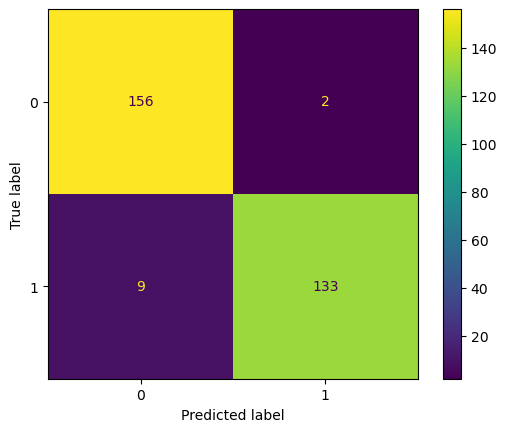

In [54]:
#plot_confusion_matrix(tfidfmod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(tfidfmod_pipe, X_test, y_test);

#### With class imbalance

- Modification to Multinomial Naive Bayes: Complement Naive Bayes
- deals with data skew.

In [55]:
from sklearn.naive_bayes import ComplementNB

Pretty much same fitting/hyperparameters.

In [56]:
from copy import deepcopy
mod_comp_pipe = deepcopy(preprocess_pipeline)
mod_comp_pipe.steps.append(('compnb', ComplementNB()))
mod_comp_pipe.steps

[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('compnb', ComplementNB())]

In [57]:
mod_comp_pipe.fit(transformed_train, y_train)



Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('compnb', ComplementNB())])

In [58]:
transformed_test = proc.transform(X_test)
y_pred_comp = mod_comp_pipe.predict(X_test)

In [59]:
print(classification_report(y_pred_comp, y_test))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       146
           1       0.99      0.91      0.95       154

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



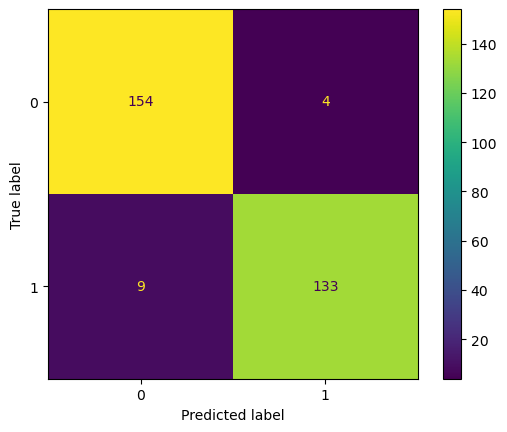

In [60]:
#plot_confusion_matrix(mod_comp_pipe, transformed_test, y_test);
ConfusionMatrixDisplay.from_estimator(mod_comp_pipe, transformed_test, y_test);

Comparable performance on this balanced dataset. Will perform *much* better on imbalanced dataset than MultinomialNB